In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
# print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import  metrics
from sklearn.model_selection import train_test_split
import IPython.display as ipd
import os
import math
%matplotlib inline
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
% cd /content/drive/MyDrive/Colab\ Notebooks/music_data
% ls 

/content/drive/.shortcut-targets-by-id/1R0W6BiPYvlf6nf4PFarJ57bi8p1jATAU/music_data
features_30_sec.csv        features_only_10_genres.csv     genres_original/
features_3_sec.csv         features_only_1.csv             genres_short/
features_country_jazz.csv  features_only_country_jazz.csv  saved_models/


In [ ]:
#!ls drive/MyDrive
#!ls drive/MyDrive/assignment\ data/arunima_fatema/our_data/

In [ ]:
#Extract Audio features and save to a csv file
#TODO-- add more features here
import librosa
from librosa import feature
import numpy as np

fn_list_i = [
 feature.chroma_stft,
 feature.spectral_centroid,
 feature.spectral_bandwidth,
 feature.spectral_rolloff
]
 
fn_list_ii = [
 feature.rms,
 feature.zero_crossing_rate
]

# Additional Features
fn_list_iii = [
  feature.mfcc,
  feature.melspectrogram
]

def get_feature_vector(y,sr): 
   feat_vect_i = [ np.mean(funct(y,sr)) for funct in fn_list_i]
   feat_vect_ii = [ np.mean(funct(y)) for funct in fn_list_ii]

   mfccs_features = librosa.feature.mfcc(y = y, sr = sr, n_mfcc=40)
   #print(mfccs_features.shape)
   mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
   feat_vect_iii = []
   for i in range(0, len(mfccs_scaled_features)):
     feat_vect_iii.append(mfccs_scaled_features[i])
   feature_vector = feat_vect_i + feat_vect_ii + feat_vect_iii
   norm_feature_vector = [float(i)/max(feature_vector) for i in feature_vector]

   return feature_vector



In [ ]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop','jazz', 'metal', 'pop', 'reggae', 'rock']
#genres = ['blues']
src_folder = '/content/drive/MyDrive/Colab Notebooks/music_data/genres_short/'
count = 1
extracted_features = []
for k in range(0, len(genres)):
  class_label = genres[k]
  path1 = src_folder + genres[k] + '_short'
  # print(path1)
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(path1)):
    # process files for specific genre
    for file in filenames:
      # print(file)
      # data = feature_extractor(path1+'/'+file)
      filename = path1+'/'+file
      #get duration in seconds
      audio, sample_rate = librosa.load(filename, sr = None)
      total_sec = math.ceil(librosa.get_duration(y=audio, sr=sample_rate))
      if(total_sec<10):
        continue
      #skip the file if it's shorter than 10 seconds
      feature_vector = get_feature_vector(audio, sample_rate)
      feature_vector.append(class_label)
      extracted_features.append(feature_vector)
      count+=1
    print('# of files processed:',count)



# of files processed: 301
# of files processed: 601
# of files processed: 901
# of files processed: 1201
# of files processed: 1501
# of files processed: 1798
# of files processed: 2098
# of files processed: 2398
# of files processed: 2698
# of files processed: 2998


In [ ]:
#saving into the csv file
import csv
norm_output = 'features_only_10_genres_with_mfcc.csv'
header =[
 'chroma_stft',
 'spectral_centroid',
 'spectral_bandwidth',
 'spectral_rolloff',
 'rmse',
 'zero_crossing_rate'
]

col_names = []
for k in range(0, 40):
  col_names.append('mfcc_'+str(k))

col_names.append('label')

header = header + col_names


with open(norm_output,'+w') as f:
 csv_writer = csv.writer(f, delimiter = ',')
 csv_writer.writerow(header)
 csv_writer.writerows(extracted_features)

# ACCESS CSV

In [ ]:
norm_output = 'features_only_10_genres_with_mfcc.csv'
new_dataset = pd.read_csv(norm_output)

In [ ]:
#pd.set_option('display.max_rows', 20)
new_dataset.head(5)

,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rmse,zero_crossing_rate,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,mfcc_21,mfcc_22,mfcc_23,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39,label
0,0.369745,1362.167172,1790.395770,2897.339943,0.052020,0.043534,-318.61400,124.27097,5.127493,32.962450,3.950289,13.759154,-4.364191,11.871619,2.284261,7.660416,-3.863900,-1.380218,-5.808335,-5.248081,-2.212185,-3.991298,-1.924902,-0.459103,1.327186,-4.182049,-4.551483,-3.446156,-0.496160,-5.733060,-6.935359,-2.017396,2.814093,-1.404512,-5.318607,-3.904047,-3.164525,-2.237151,-0.984121,-1.472591,-3.442031,-3.191879,-2.560669,-1.931898,-1.531901,0.637063,blues
1,0.379309,1340.996909,1697.884199,2788.949493,0.068632,0.048506,-278.13354,129.90216,4.716898,31.390368,-3.581936,14.044489,-4.508615,7.902548,-1.213723,5.866328,-5.425708,-3.718602,-6.077432,-7.516737,-3.119838,-3.179776,-3.164547,-2.213597,2.370741,-4.701198,-5.721228,-4.467641,-2.742660,-7.767584,-8.566476,-3.445348,0.890269,-2.449619,-4.616578,-2.759344,-1.141782,-1.345999,-2.221646,-2.159076,-4.243951,-4.169820,-2.590714,-2.194951,-1.153114,1.493249,blues
2,0.354039,1357.278823,1786.322398,2973.105843,0.076420,0.039550,-272.11002,124.72246,0.261534,42.204220,-1.710111,20.187763,-9.052547,8.933455,-1.066578,8.150405,-6.834039,-3.322553,-5.425649,-7.197440,-2.634124,-1.868097,-4.818281,-3.163327,2.169292,-6.201232,-5.943323,-3.236554,-2.632051,-6.341493,-4.833918,-3.092111,1.396508,-1.855052,-4.066506,-3.277985,-2.482724,-2.071058,-2.479438,-0.378495,-1.139163,-0.624861,1.249026,-0.048551,-1.175910,0.306750,blues
3,0.309263,1404.295102,1485.725864,2666.944662,0.126589,0.067351,-199.10650,139.38283,-31.261417,28.903522,-15.892096,6.258377,-11.269325,8.458337,-4.707657,0.956576,-2.693551,3.014071,-3.306016,-0.247295,-0.284500,-2.164301,1.887707,-0.788992,-0.481315,-3.191337,-1.738598,-3.750919,-1.127961,-6.512488,-3.746323,3.542814,10.375946,15.094035,14.631495,3.316522,-0.382641,-5.421751,-4.564389,0.826181,-3.502117,-4.401218,-6.100995,-0.930285,3.153065,1.423163,blues
4,0.310806,1255.056763,1410.350739,2361.133209,0.162718,0.055346,-151.65512,153.82776,-22.729889,27.687372,-16.181238,2.665511,-17.048690,6.487762,-5.924068,0.553178,-2.622914,0.514069,-6.735596,-1.814035,-0.306821,-5.374805,-1.151545,-4.605759,-2.542818,-5.436125,2.803128,7.340156,10.705073,5.488626,-1.071154,-5.117333,-3.725874,1.651373,2.089980,-2.166187,-3.060543,-5.403781,-3.148306,0.569581,-4.760603,-8.244643,-6.792371,-1.512968,1.776621,-0.791258,blues


In [ ]:
#check out the labels/genres
new_dataset['label'].value_counts()

disco        300
hiphop       300
blues        300
metal        300
reggae       300
classical    300
country      300
rock         300
pop          300
jazz         297
Name: label, dtype: int64

In [ ]:
# changing Genres labels from text to numbers
from sklearn.preprocessing import LabelEncoder as LE 

Genres_label = new_dataset.iloc[:,-1]
genres_to_labels = LE()
new_target = genres_to_labels.fit_transform(Genres_label)

In [ ]:
# Normalizing

from sklearn.preprocessing import StandardScaler
fit = StandardScaler()
input = fit.fit_transform(np.array(new_dataset.iloc[:,:-1], dtype = float))

In [ ]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(input, new_target, test_size = 0.2, random_state = 0)

In [ ]:
X_train.shape

(2397, 46)

In [ ]:
len(X_test)

600

In [ ]:
def trainModel(model,epochs,optimizer):
  batch_size=128
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics='accuracy')
  return model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch_size)

In [ ]:
model=keras.models.Sequential([
                         keras.layers.Dense(100,activation='relu',input_shape=(X_train.shape[1],)),
                         keras.layers.Dropout(0.2),
                         keras.layers.Dense(200,activation='relu'),
                         keras.layers.Dropout(0.2),
                         keras.layers.Dense(128,activation='relu'),
                         keras.layers.Dropout(0.2),
                         keras.layers.Dense(64,activation='relu'),
                         keras.layers.Dropout(0.2),
                         keras.layers.Dense(10,activation='softmax')
])
print(model.summary())
model_history=trainModel(model=model,epochs=100,optimizer='adam')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 100)               4700      
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_16 (Dense)            (None, 200)               20200     
                                                                 
 dropout_13 (Dropout)        (None, 200)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               25728     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 64)               

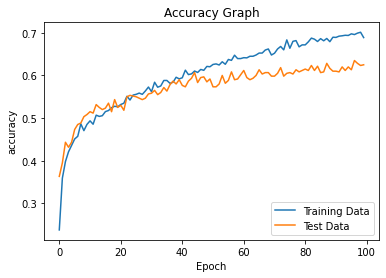

In [ ]:
#Plot the Accuray curves
import matplotlib.pyplot as plt
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['Training Data','Test Data'],loc='lower right')
plt.show()

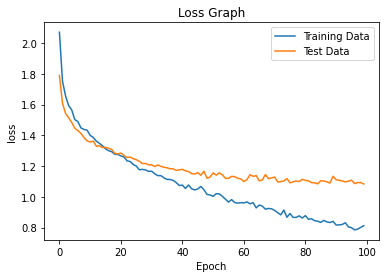

In [ ]:
#Plot the loss curves
import matplotlib.pyplot as plt
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['Training Data','Test Data'],loc='upper right')
plt.show()

# End

In [ ]:
# to show the plot of each audio file
def show_plot(filename):
  plt.figure(figsize=(14, 5))
  data, sample_rate = librosa.load(filename)
  print(data.shape)
  print(sr)
  librosa.display.waveplot(data, sr=sample_rate)


(220500,)
22050


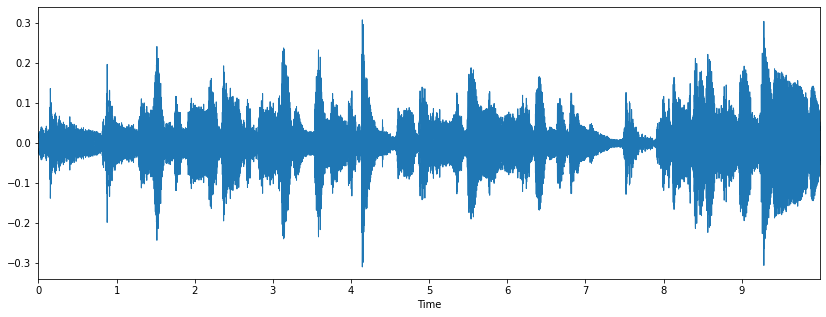

In [ ]:
### This is a simple test to load an audio file and play it

fname = '/content/drive/MyDrive/Colab Notebooks/music_data/genres_short/jazz_short/10_jazz.00099.wav'

plt.figure(figsize=(14, 5))
data, sample_rate = librosa.load(fname)
print(data.shape)
print(sample_rate)
librosa.display.waveplot(data, sr=sample_rate)
ipd.Audio(fname)


In [ ]:
### model

num_labels = len(genres)

# first layer
model = Sequential()
model.add(Dense(100, input_shape = (X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
# compile model

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')

In [ ]:
## Trianing the model

from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

# #checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
#                                verbose=1, save_best_only=True)
# #start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)


#duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100


ValueError: ignored

#  Other codes

In [ ]:
src_folder = '/content/drive/MyDrive/Colab Notebooks/music_data/genres_short'
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(src_folder)):
  # process files for specific genre
  for file in filenames:
    if(file==str("jazz.00054.wav")):
      # As librosa only read files <1Mb
      continue
      split_wav = SplitWavAudioMubin(src_folder, dest_folder, file)
      split_wav.multiple_split(sec_per_split=10)
      count+=1
  print('# of files processed:',count)

NameError: ignored

In [ ]:
#### extracting features from an audio file
def feature_extractor(filename):
  #print(filename)
  audio, sample_rate = librosa.load(filename, res_type='kaiser_fast')
  mfccs_features = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc=40)
  #print(mfccs_features.shape)
  mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

  return mfccs_scaled_features

In [ ]:
#### Load all music files and extract features

path1 = 'drive/MyDrive/assignment data/arunima_fatema/our_data/genres_original/'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop','jazz', 'metal', 'pop', 'reggae', 'rock']

# 'blues', 'classical', 'country', 'disco', 'hiphop','jazz', 'metal', 'pop', 'reggae', 'rock'
extracted_features = []
n_files = 100

for i in range(0, len(genres)):
  class_label = genres[i] 
  #print(genres[i])
  for j in range(0, n_files):
    if (j < 10):
      st = genres[i] + '.' + '0000' + str(j) + '.wav'
    else:
      st = genres[i] + '.' + '000' + str(j) + '.wav'
    filename = path1 + genres[i] + '/'+ st
    # print(filename)
    if(j == 54):
      continue
    data = feature_extractor(filename)
    #play_audio(filename)
    #show_plot(filename)
    extracted_features.append([data, class_label])





In [ ]:
# converting extracted feature to Pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'music_genre'])
extracted_features_df.head()

In [ ]:
# split the dataset into feature and music genre class
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['music_genre'].tolist())

In [ ]:
X.shape


In [ ]:
## Label Encoding
y = np.array(pd.get_dummies(y))


In [ ]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
X_train.shape

In [ ]:
X_test.shape
X_test


# Model Creation

In [1]:
num_labels = y.shape[1]

NameError: ignored

In [ ]:
### model

# first layer
model = Sequential()
model.add(Dense(100, input_shape = (40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
model.summary()

In [ ]:
# compile model

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')

In [ ]:
## Trianing the model

from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])